# Build Retrieval Augmented Generation Intelligent Query Agent
In the following use case example, we’ll showcase how Cohere’s Generate, Embed, and Reranker model can search and
query across a repository of financial reports and articles.

### Step 1: Install Packages, Import Modules, and Create Model Endpoints

In [ ]:
!pip install --upgrade cohere-aws cohere hnswlib pandas numpy markdown boto3 -q
# If you upgrade the package, you need to restart the kernel

### Step 2: Import, create endpoints, transform and chunk data set

In [ ]:
import pandas as pd
import cohere_aws
import cohere
import hnswlib
import warnings
import boto3
import json
import markdown as md
from IPython.display import HTML
warnings.filterwarnings('ignore')


#### Connect to Command, Embed and Rerank endpoints

In [ ]:
#connect to Bedrock endpoint for Command
co_chat = cohere_aws.Client(mode=cohere_aws.Mode.BEDROCK)
model_id_chat = "cohere.command-r-plus-v1:0"

#connect to Bedrock endpoint for embed
co_em = cohere_aws.Client(mode=cohere_aws.Mode.BEDROCK)
model_id_em = "cohere.embed-english-v3"

#connect to existing SageMaker endpoint for Rerank, change the endpoint name if different
co_rk = cohere_aws.Client(region_name='us-east-1')
co_rk.connect_to_endpoint(endpoint_name="cohere-rerank-multilingual")


#### Import data set and split them into chunks

In [ ]:
s3 = boto3.client('s3')

def iterate_bucket_items(bucket):
    text = []
    names = []


    result = s3.list_objects(Bucket = bucket)
    for o in result.get('Contents'):
        data = s3.get_object(Bucket=bucket, Key=o.get('Key'))
        text.append(str(data['Body'].read()))
        names.append(str(o.get('Key'))),
    return text, names


bucket = "finserv-analyst-reports"
text, names = iterate_bucket_items(bucket)
df = pd.DataFrame({'text': text, 'name': names})

# Read the data
print(f'Total number of financial reports imported : {len(df)}')


In [ ]:
#Inspect the dataframe
df.head(5)

In [ ]:
#split each article into chunks of n words or less return a list of tuples (chunk, original text) with an overlap of m words
def split_text(text,name, n, m=0):
    words = text.split()
    chunks = []
    for i in range(0, len(words), n-m):
        chunk = ' '.join(words[i:i+n])
        chunks.append((chunk, text, name))
    return chunks

df = df.drop_duplicates()
chunks = []
for i, row in df.iterrows():
    chunks.extend(split_text(row['text'], row['name'],150, 15))
df = pd.DataFrame(chunks, columns=['chunk', 'original_text', 'name'])
print(f'The reports were split into a total number of {len(df)} chunks')

### Step 3: Bulk Embed and Index Documents

In [ ]:
# Embed documents
# def embed_docs():
doc_embs =[]
docs = df['chunk'].to_list()
input_type = 'search_document'

batch_size=96

from tqdm import tqdm
for i in tqdm(range(0, len(docs), batch_size)):

    batch_docs = docs[i:i+batch_size]
    response = co_em.embed(
        texts=batch_docs, 
        input_type=input_type, 
        model_id=model_id_em
    )
    doc_embs.extend(response.embeddings)

# doc_embs, docs = embed_docs()
print(f'Total Documents embedded : {len(docs)}')    
        
#     return doc_embs, docs

In [ ]:
## Create a search index with hnswlib, a library for fast approximate nearest neighbor search

index = hnswlib.Index(space='ip', dim=1024) # Cohere embed outputs embeddings with 1024 dimensions
index.init_index(max_elements=len(doc_embs), ef_construction=1024, M=64) # For more info: https://github.com/nmslib/hnswlib#api-description
index.add_items(doc_embs, list(range(len(doc_embs))))

### Step 4: Query the Datastore

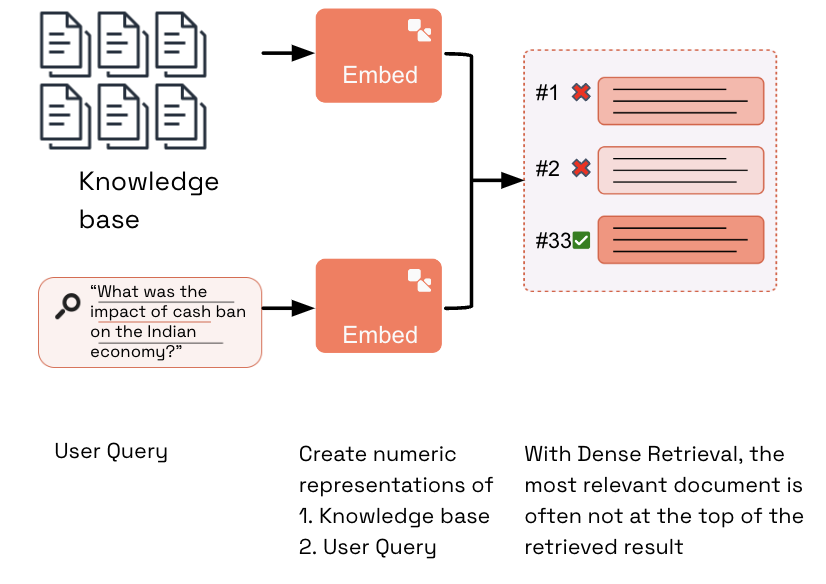

In [ ]:
def retrieval(query, chat):
    docs = df['chunk'].to_list()

    # Embed query and retrieve results
    query_emb = co_em.embed(texts=[query], model_id=model_id_em, input_type="search_query").embeddings
    
    doc_ids = index.knn_query(query_emb, k=15)[0][0] # we will retrieve 15 closest neighbors

    if not chat:
        print(f"DOCUMENT IDs returned => {doc_ids} \n" )
        print(f"-> QUERY: '{query.upper()}' \n")
        print("-> Printing first 2 Results out of the total: \n")

    retrieved_docs = []
    
    for doc_id in doc_ids:
        # Append results
        retrieved_docs.append(docs[doc_id])

    # Print results
    if not chat:
        for doc_id in doc_ids[:2]:
            print("\t{}\t{}".format(doc_id, docs[doc_id].replace("\n", " ")))
        
    return retrieved_docs

In [ ]:
# Dense retrieval does return the search results. However the most relevant results may not always be at 
# the top of the retrieved dataset

query = 'Impact of cash ban on the Indian economy'
retrieved_docs = retrieval(query, False)


### Step 5: Improve Results with Cohere Rerank

The following query is not returning the most relevant result at the top, here is where Rerank will help.

In [ ]:
def rerank_retrieval(query, chat):
    results = co_rk.rerank(query=query,documents=retrieved_docs, top_n=5)
    re_ranked_docs=[]
    for idx, r in enumerate(results):
        if not chat:
            print("\t{} was(#{})\t{}\t{}".format(idx + 1,r.index,r.relevance_score,r.document["text"].replace("\n", " ")))
        re_ranked_docs.append({"text": r.document['text']})
    
    return re_ranked_docs

In [ ]:
re_ranked_docs = rerank_retrieval(query, False)

### Step 6: Bringing it all together - Using Cohere Command, Embed and Rerank
Generate query responses from the reranked document set; Guide the model to produce responses based on a preamble; Add citations for results produced; 

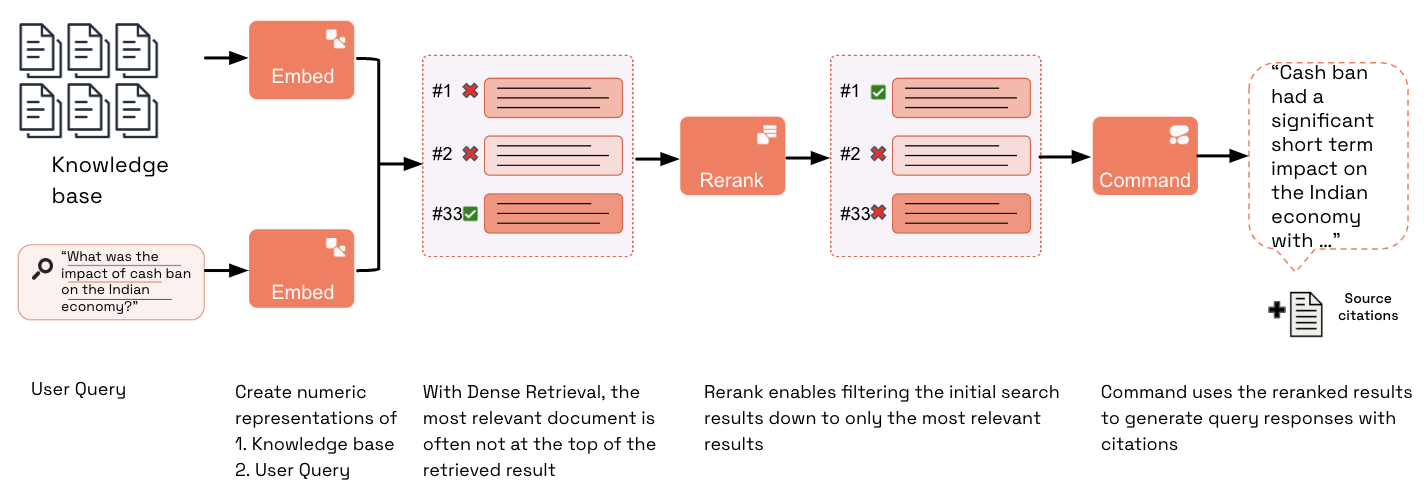

In [ ]:
preamble = "You are a helpful digital assistant. \nPlease answer questions only based on the contents of the documents. \nIf the documents do not contain the answers to my question please say I dont know."
print(preamble)

In [ ]:
class Chatbot:
    def run(self):
        """
        Runs the chatbot application.

        """
        while True:
            # Get the user message
            message = input("User: ")

            # Typing "quit" ends the conversation
            if message.lower() == "quit":
              print("Ending chat.")
              break
            # Generate search queries (if any)
            response = co_chat.chat(message=message,model_id=model_id_chat,search_queries_only=True)

            # If there are search queries, retrieve document chunks and respond
            if response.search_queries:
                print("Retrieving information...", end="")

                # Retrieve relevant document chunks for inputted query
                retrieved_docs = retrieval(message,True)
                # Rerank documents before passing the documents to the generative model
                re_ranked_docs = rerank_retrieval(message,True)
    
                # Use reranked document chunks to respond
                print ("\nUsing Re-ranked docs to respond...")
                response = co_chat.chat(
                    message=message,
                    model_id=model_id_chat,
                    preamble = preamble,
                    documents=re_ranked_docs,
                    stream=True
                )

            # If there is no search query, directly respond
            # No RAG
            else:
                response = co_chat.chat(
                    message=message,
                    model_id=model_id_chat,
                    stream=True
                )

            # Print the chatbot response, citations, and documents
            citations = []
            cited_documents = []
            cited_document_ids = []
            unique_cited_document_ids = []

            print("\nRESPONSE:")

            # Display response
            for event in response:
                #print (event)
                if event.event_type == "text-generation":
                    print(event.text, end="")
                elif event.event_type == "citation-generation":
                    citations.extend(event.citations)
                elif event.event_type == "search-results":
                    cited_documents = event.documents


            # Display citations and source documents
            if citations:
                print("\n\nCITATIONS:")
                for citation in citations:
                  print(citation)
                  for ids in citation['document_ids']:
                      cited_document_ids.append(ids)

                unique_cited_document_ids = list(dict.fromkeys(cited_document_ids))

                print("\nDOCUMENTS:")
                for document in cited_documents:
                  if document['id'] in unique_cited_document_ids:
                   print(document)
                   print(f"\n{'-'*100}\n") 

In [ ]:
# Create an instance of the Chatbot class
chatbot = Chatbot()

# Run the chatbot
chatbot.run()

### Step 7: Clean-up
Delete the endpoints

In [ ]:
# co_rk.delete_endpoint()
# co_rk.close()